In [1]:

%run ../../load_magic/storage.py
%run ../../load_magic/dataframes.py
%run ../../load_magic/environment.py
%pprint
notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
print([fn for fn in dir(s) if not fn.startswith('_')])
%who

Pretty printing has been turned OFF
C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\ipynb\US Cities older than the US.ipynb
data_folder: ../data/
saves_folder: ../saves/
['attempt_to_pickle', 'data_csv_folder', 'data_folder', 'encoding_type', 'load_csv', 'load_dataframes', 'load_object', 'save_dataframes', 'saves_csv_folder', 'saves_folder', 'saves_pickle_folder', 'store_objects']
Config	 Storage	 csv	 example_iterrows	 get_column_descriptions	 get_max_rsquared_adj	 get_module_version	 get_notebook_path	 get_page_tables	 
ipykernel	 json	 jupyter_config_dir	 math	 notebook_path	 notebookapp	 os	 pd	 pickle	 
s	 sm	 sys	 urllib	 


In [2]:

tables_url = 'https://en.wikipedia.org/wiki/List_of_cities_in_the_Americas_by_year_of_foundation'
tables_df_list = get_page_tables(tables_url)

[(1, (741, 6)), (0, (1, 2))]


In [3]:

cities_df = tables_df_list[1].copy().dropna(axis='columns', how='all')
#print([fn for fn in dir(cities_df) if 'na' in fn.lower()])

In [4]:

countries_list = [c for c in cities_df['Country'].unique().tolist() if 'States' in c]

In [5]:

import re

year_regex = re.compile(r'(\d+)( BC| \(prior to\))?', re.MULTILINE)
def f(x):
    match_obj = year_regex.search(str(x))
    if match_obj:
        year_number = int(match_obj.group(1))
        if match_obj.group(2) == ' BC':
            year_number = -year_number
    else:
        year_number = pd.np.nan
    
    return year_number

cities_df['Year'] = cities_df['Year'].map(f)

In [8]:

from geopy.geocoders import Nominatim
import geopy

default_user_agent = geopy.geocoders.options.default_user_agent
geolocator = Nominatim(user_agent='my-application')

In [9]:

match_series = cities_df['Country'].isin(countries_list) & (cities_df['Year'] < 1776)
cities_df[match_series].sort_values('Year')

,Year,City,"State, province, dept., etc.",Country,Notes
14,600,Cahokia,Illinois,United States,NaN
17,1000,Acoma Pueblo and Taos Pueblo,New Mexico,United States,NaN
21,1100,Oraibi,Arizona,United States (Hopi Reservation),[2]
26,1450,Zuni Pueblo,New Mexico,United States,[3]
37,1508,Caparra,Puerto Rico,United States,"First city founded by Europeans, although not ..."
...,...,...,...,...,...
445,1769,San Diego,California,United States,Grew from Presidio of San Diego
447,1770,Monterey,California,United States,Grew from Presidio of Monterey. Original capit...
451,1775,Tucson,Arizona,United States,NaN
453,1775,Lexington,Kentucky,United States,NaN


In [ ]:

cities_df['latitude_float'] = pd.np.nan
cities_df['longitude_float'] = pd.np.nan
location_regex = re.compile(r'(\d+)\.(\d+)°N (\d+)\.(\d+)°W')
for row_index, row_series in cities_df.iterrows():
    city_str = row_series['City']
    state_str = row_series['State, province, dept., etc.']
    location_str = '{}, {}'.format(city_str, state_str)
    #location_tuple = geolocator.geocode(location_str)
    #if location_tuple is not None:
        #print('{}: {}'.format(location_str, location_tuple))
    url_str = re.sub(' ', '_', location_str)
    tables_url = 'https://en.wikipedia.org/wiki/{}'.format(url_str)
    try:
        tables_df_list = get_page_tables(tables_url, verbose=False)
    except Exception as e:
        #print('{} got an error: {}'.format(tables_url, e))
        tables_df_list = []
    shapes_list = sorted([(i, df.shape) for (i, df) in enumerate(tables_df_list) if df.shape[1] == 2],
                         key=lambda x: x[1][0], reverse=True)
    while len(shapes_list) > 0:
        tuple_tuple = shapes_list.pop()
        i = tuple_tuple[0]
        infobox_list = tables_df_list[i].iloc[:, 0].tolist()
        coords_list = [x for x in infobox_list if 'Coordinates:' in str(x)]
        if len(coords_list):
            coords_list = coords_list[0].split('Coordinates: ')
            location_str = coords_list[1]
            match_obj = location_regex.search(location_str)
            if match_obj:
                latitude_int = int(match_obj.group(1))
                latitude_frac = int(match_obj.group(2))
                latitude_float = float('{}.{}'.format(latitude_int, latitude_frac))
                longitude_int = int(match_obj.group(3))
                longitude_frac = int(match_obj.group(4))
                longitude_float = float('{}.{}'.format(longitude_int, longitude_frac))
                #print(latitude_float, longitude_float)
                cities_df.loc[row_index, 'latitude_float'] = latitude_float
                cities_df.loc[row_index, 'longitude_float'] = longitude_float
                s.store_objects(cities_df=cities_df)
                shapes_list = []

In [28]:

cities_df['longitude_float'] = cities_df['longitude_float'].map(lambda x: -x)

In [29]:

match_series = cities_df['Country'].isin(countries_list) & (cities_df['Year'] < 1776)
match_series = match_series & ~cities_df['latitude_float'].isnull() & ~cities_df['longitude_float'].isnull()
cities_df[match_series]

,Year,City,"State, province, dept., etc.",Country,Notes,latitude_float,longitude_float
14,600,Cahokia,Illinois,United States,NaN,38.56194,-90.17278
26,1450,Zuni Pueblo,New Mexico,United States,[3],35.69440,-108.84667
50,1521,San Juan,Puerto Rico,United States,Oldest continuously inhabited European establi...,18.40639,-66.63890
155,1565,Saint Augustine,Florida,United States,Oldest continuously inhabited European establi...,29.89472,-81.31444
177,1579,Coamo,Puerto Rico,United States,Third oldest European settlement in Puerto Ric...,18.80000,-66.35806
...,...,...,...,...,...,...,...
443,1769,Elizabethton,Tennessee,United States,NaN,36.33639,-82.23917
445,1769,San Diego,California,United States,Grew from Presidio of San Diego,32.71500,-117.16250
447,1770,Monterey,California,United States,Grew from Presidio of Monterey. Original capit...,36.60306,-121.89361
451,1775,Tucson,Arizona,United States,NaN,32.22167,-110.92639


In [30]:

print(os.environ['PROJ_LIB'])

C:\Users\Dave Babbitt\Anaconda3\Library\share


In [3]:

import sys

print('{} -m pip install --upgrade ipykernel_launcher'.format(sys.executable))
!{sys.executable} -m pip install --upgrade ipykernel_launcher

C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade ipykernel_launcher


  ERROR: Could not find a version that satisfies the requirement ipykernel_launcher (from versions: none)
ERROR: No matching distribution found for ipykernel_launcher


C:\Users\dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


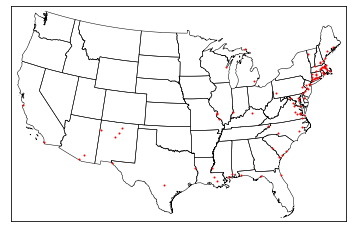

In [35]:

# Draw the locations of cities on a map of the US
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math

scale = 5

map = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,
              projection='lcc', lat_1=32, lat_2=45, lon_0=-95)

# load the shapefile, use the name 'states'
map.readshapefile(r'C:\Users\dev\Documents\repositories\basemap\examples\st99_d00', name='states', drawbounds=True)

# Get the location of each city and plot it
geolocator = Nominatim(user_agent='my-application')
match_series = cities_df['Country'].isin(countries_list) & (cities_df['Year'] < 1776)
match_series = match_series & ~cities_df['latitude_float'].isnull() & ~cities_df['longitude_float'].isnull()
for row_index, row_series in cities_df[match_series].iterrows():
    x, y = map(row_series.longitude_float, row_series.latitude_float)
    map.plot(x, y, marker='o', color='Red', markersize=1)